<a href="https://colab.research.google.com/github/ekaterinatao/hackathon_books_text_classification/blob/main/code_sber_ruRoberta_ru_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Результаты
Отчет на [wandb](https://wandb.ai/iliabel/books_text_class_ruROBERTa_iliabel_v2/runs/n99dyrbb?workspace=user-ilia-beliakov)  
Веса модели на [huggingface](https://huggingface.co/ekaterinatao/books_text_class_roBERTa_ru_big/tree/main)

### Установка зависимостей

In [1]:
!pip install datasets evaluate seqeval -qqq
!pip install accelerate -U -qqq
!pip install wandb -qqq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification
from transformers import EvalPrediction
from transformers import TrainingArguments, Trainer
import evaluate

import warnings
warnings.filterwarnings("ignore")

### Скачивание датасета

In [3]:
# PATH to data
url = 'https://raw.githubusercontent.com/ekaterinatao/hackathon_books_text_classification/main/data/data_new.csv'

data_raw = pd.read_csv(
    url, sep='\t', header=0, names=['text', 'tag']
)
data_raw.head(5)

,text,tag
0,XXXVII,title
1,XXXVI,title
2,XXXV,title
3,XXXIV,title
4,XXXII. Светлое воскресенье,title


In [4]:
data_raw.shape

(111743, 2)

In [5]:
data_raw['tag'].nunique()

10

In [4]:
le = LabelEncoder()
data_raw['labels'] = le.fit_transform(data_raw['tag'])

In [5]:
import collections
ind_to_label = {i:label for i, label in zip(data_raw['labels'], data_raw['tag'])}
labels_dict = collections.OrderedDict(reversed(ind_to_label.items()))
labels_dict

OrderedDict([(0, 'annotation'),
             (1, 'author'),
             (2, 'book-title'),
             (3, 'cite'),
             (4, 'epigraph'),
             (5, 'note'),
             (6, 'p'),
             (7, 'poem'),
             (8, 'subtitle'),
             (9, 'title')])

### Подготовка данных к загрузке в DataLoader

In [ ]:
data_raw['tag'].value_counts()

subtitle      23456
poem          20000
p             20000
title         19999
cite          15252
epigraph       4404
note           3905
annotation     2303
author         1280
book-title     1144
Name: tag, dtype: int64

In [ ]:
train_text, val_text = train_test_split(
    data_raw, test_size=0.2, random_state=42
)
print(f'train: {len(train_text)}, val: {len(val_text)}')

train: 89394, val: 22349


In [ ]:
train_text['tag'].value_counts(normalize=True) * 100

subtitle      21.004765
p             17.892700
title         17.866971
poem          17.759581
cite          13.716804
epigraph       3.959997
note           3.538269
annotation     2.059422
author         1.176813
book-title     1.024677
Name: tag, dtype: float64

In [ ]:
val_text['tag'].value_counts(normalize=True) * 100

subtitle      20.936060
poem          18.452727
title         18.018703
p             17.920265
cite          13.378675
epigraph       3.865945
note           3.320059
annotation     2.067207
author         1.020180
book-title     1.020180
Name: tag, dtype: float64

In [ ]:
dataset = DatasetDict({
    'train': Dataset.from_pandas(train_text),
    'valid': Dataset.from_pandas(val_text)
})
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__'],
        num_rows: 89394
    })
    valid: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__'],
        num_rows: 22349
    })
})

___
### Токенизация с помощью модели [RoBERTa](https://huggingface.co/DeepPavlov/xlm-roberta-large-en-ru-mnli)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
def preprocess_data(examples):
    encoding = tokenizer(examples['text'], truncation=True, max_length=512)
    return encoding

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("ai-forever/ruRoberta-large")

config.json:   0%|          | 0.00/674 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.81M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.37M [00:00<?, ?B/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding=True)

encoded_dataset = dataset.map(preprocess_data, batched=True)
encoded_dataset.set_format("torch")
encoded_dataset

Map:   0%|          | 0/89394 [00:00<?, ? examples/s]

Map:   0%|          | 0/22349 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 89394
    })
    valid: Dataset({
        features: ['text', 'tag', 'labels', '__index_level_0__', 'input_ids', 'attention_mask'],
        num_rows: 22349
    })
})

### Обучение модели

In [ ]:
ACCURACY = evaluate.load("accuracy")
F1 = evaluate.load("f1")
MCC = evaluate.load("matthews_correlation")

def compute_metrics(p: EvalPrediction):
    preds = p.predictions
    preds = np.argmax(preds, axis=1)

    acc_result = ACCURACY.compute(predictions=preds, references=p.label_ids)
    f1_result = F1.compute(predictions=preds, references=p.label_ids, average='weighted')
    mcc_result = MCC.compute(predictions=preds, references=p.label_ids)
    result = {
        "accuracy": acc_result["accuracy"],
        "f1-score": f1_result["f1"],
        "mcc": mcc_result["matthews_correlation"]
    }

    return result

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
import os
os.environ["WANDB_PROJECT"]="books_text_class_ruROBERTa_iliabel_v2"

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "ai-forever/ruRoberta-large", num_labels=12
)

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruRoberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
repo_id = "/content/gdrive/MyDrive/Хакатон_2312/" #Прописать путь к google drive

training_args = TrainingArguments(
    output_dir=repo_id,
    learning_rate=1e-05,
    per_device_train_batch_size=10, #если забьется память, уменьшить до 5
    per_device_eval_batch_size=10,
    num_train_epochs=3,
    #weight_decay=0.0001,
    evaluation_strategy="epoch",
    # push_to_hub=True,
    report_to="wandb",
    run_name="iliabel_run_2",
    save_strategy="no",
    group_by_length=True,
    warmup_ratio=0.1,
    optim="adamw_torch",
    lr_scheduler_type="cosine",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["valid"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: Currently logged in as: ilia-beliakov (iliabel). Use `wandb login --relogin` to force relogin


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,F1-score,Mcc
1,0.268700,0.287761,0.936597,0.935046,0.924255
2,0.196700,0.247234,0.947067,0.947358,0.936800
3,0.094200,0.259923,0.951005,0.950913,0.941447


TrainOutput(global_step=26820, training_loss=0.2566787682745903, metrics={'train_runtime': 4398.9498, 'train_samples_per_second': 60.965, 'train_steps_per_second': 6.097, 'total_flos': 2.956852008183931e+16, 'train_loss': 0.2566787682745903, 'epoch': 3.0})

In [ ]:
wandb.finish()

eval/accuracy,▁▆█
eval/f1-score,▁▆█
eval/loss,█▁▃
eval/mcc,▁▆█
eval/runtime,█▁▆
eval/samples_per_second,▁█▃
eval/steps_per_second,▁█▃
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,▂▄▅███████▇▇▇▇▇▆▆▆▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train/loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [ ]:
trainer.save_model(repo_id)

### Оценка качества на тестовой выборке

In [ ]:
predictions = trainer.predict(test_dataset=encoded_dataset["valid"])

In [ ]:
predictions.metrics

{'test_loss': 0.2599230110645294,
 'test_accuracy': 0.9510045192178621,
 'test_f1-score': 0.9509130953651778,
 'test_mcc': 0.94144689722347,
 'test_runtime': 242.5081,
 'test_samples_per_second': 92.158,
 'test_steps_per_second': 9.216}

In [ ]:
preds = predictions.predictions
predicted_labels = np.argmax(preds, axis=1)
print(predicted_labels.shape)
predicted_labels

(22349,)


array([6, 8, 3, ..., 8, 3, 1])

In [ ]:
true_labels = encoded_dataset['valid']['labels']
print(true_labels.shape)
true_labels

torch.Size([22349])


tensor([6, 8, 3,  ..., 8, 3, 1])

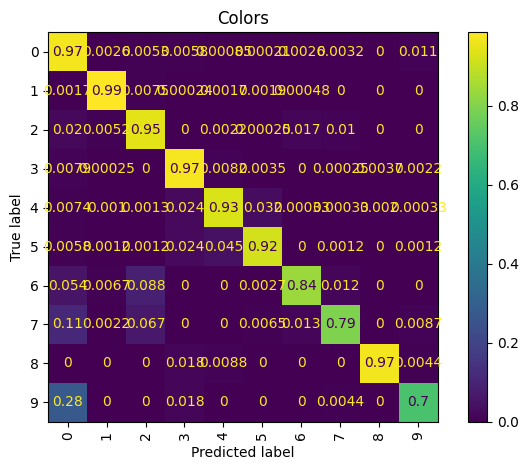

In [ ]:
cn_matrix = confusion_matrix(
    y_true = le.inverse_transform(true_labels.tolist()),
    y_pred = le.inverse_transform(predicted_labels.tolist()),
    labels = le.inverse_transform(data_raw['labels'].value_counts().index).tolist(),
    normalize="true",
)
ConfusionMatrixDisplay(cn_matrix).plot(
    include_values=True, xticks_rotation="vertical"
)
plt.title("Colors")
plt.tight_layout()
plt.show()

In [6]:
# значения лэйблов
labels_dict

OrderedDict([(0, 'annotation'),
             (1, 'author'),
             (2, 'book-title'),
             (3, 'cite'),
             (4, 'epigraph'),
             (5, 'note'),
             (6, 'p'),
             (7, 'poem'),
             (8, 'subtitle'),
             (9, 'title')])